In [1]:
!pip install caer canaro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 33.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling ten

In [2]:
import os
import numpy as np
import cv2 as cv
import caer
import canaro
import gc

# Some Parameters: Data Set's Path, GrayScale Images, 80x80 Images Size

In [3]:
IMG_SIZE=(80,80)
channels =1
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'


# Build a dictionary with all the characters in the dataset, sorted by quantity of images in descendent order.

In [4]:
char_dict= {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))
                           
# Sort dictionary in descendent order

char_dict = caer.sort_dict(char_dict,descending = True)
                        

# Took the 10 first characters (the ones with most data images) and assign it an index number in a list

In [5]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count+=1
    if count == 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

# Create a Training Data using caer. Each character has a folder with its images inside.  Character label will take the folder names as label.

In [6]:
#Create a training data

train = caer.preprocess_from_dir(char_path,characters,channels= channels, IMG_SIZE = IMG_SIZE,isShuffle=True)


[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 2.850114107131958s
[INFO] At 1000 files
[INFO] 1454 files found in 0.9657449722290039s
[INFO] At 1000 files
[INFO] 1452 files found in 1.0339648723602295s
[INFO] At 1000 files
[INFO] 1354 files found in 0.5879521369934082s
[INFO] At 1000 files
[INFO] 1342 files found in 0.5333011150360107s
[INFO] At 1000 files
[INFO] 1291 files found in 0.41868138313293457s
[INFO] At 1000 files
[INFO] 1206 files found in 0.20972228050231934s
[INFO] At 1000 files
[INFO] 1194 files found in 0.14265990257263184s
[INFO] At 1000 files
[INFO] 1193 files found in 0.22059965133666992s
[INFO] At 1000 files
[INFO] 1079 files found in 0.003574848175048828s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 2m 16s


# Show a sample image

In [7]:
import matplotlib.pyplot as plt

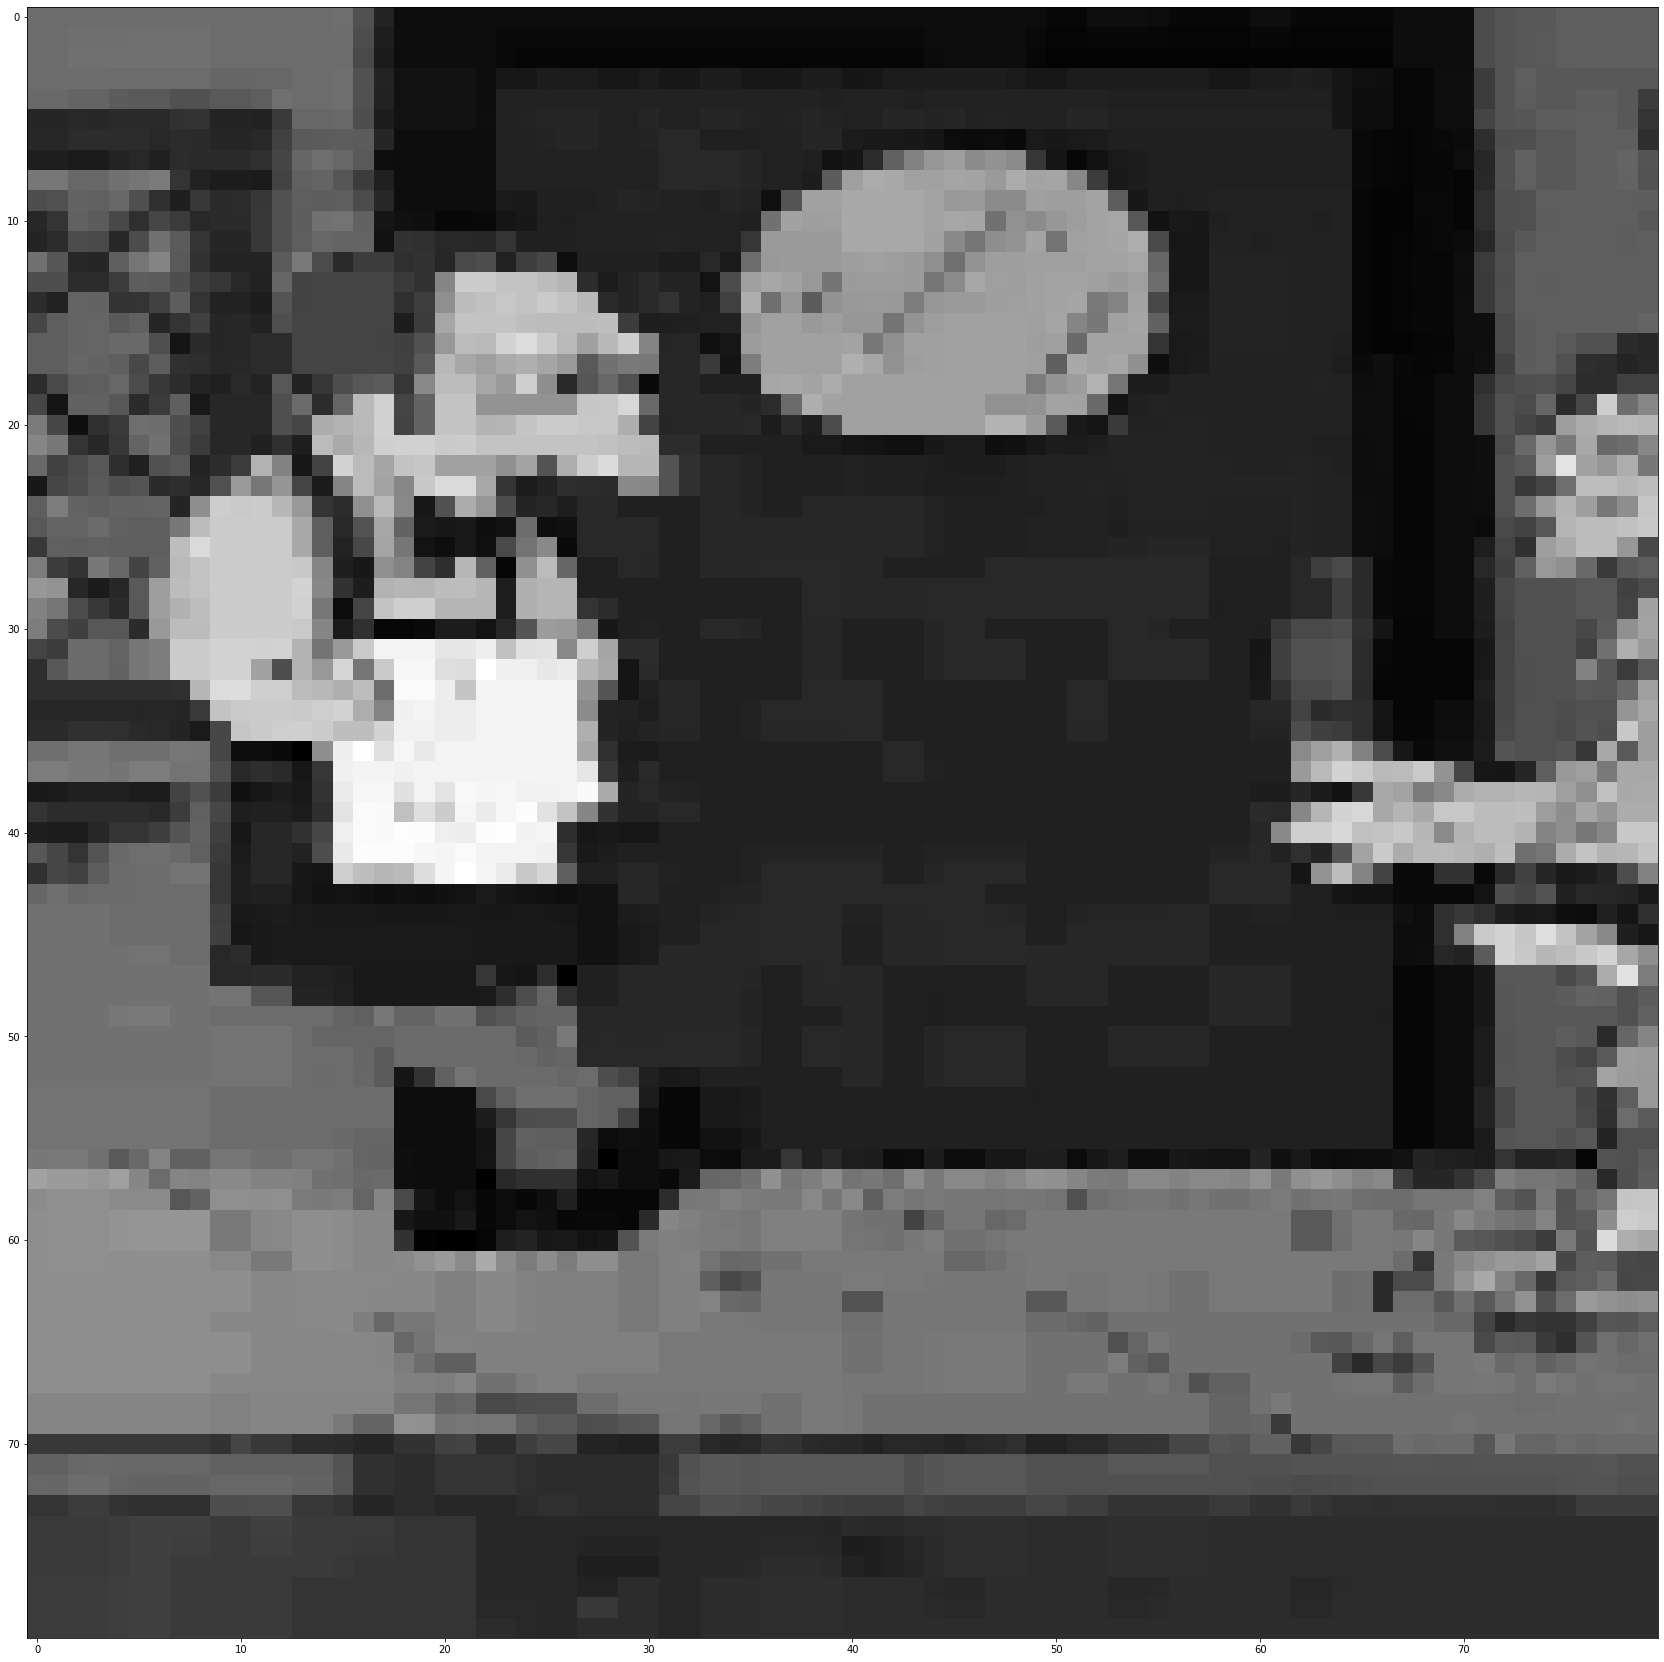

In [8]:
plt.figure(figsize=(30,30))
plt.imshow(train[0][0],cmap='gray')
plt.show()


# Initialize a Training Dataset

In [9]:
featureSet, labels = caer.sep_train(train,IMG_SIZE=IMG_SIZE)

# Normalize the training dataset (0-1)

In [10]:
from tensorflow.keras.utils import to_categorical

In [11]:
#Normalize the featureSet =>(0.1)

featureSet = caer.normalize(featureSet)
labels = to_categorical(labels,len(characters))


# Take a 20% of the training data set as Validation Set

In [12]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet,labels,val_ratio=0.2)

In [13]:
len(y_val)


2764

# Relase memory by deleting data no longer needed

In [14]:
del train
del featureSet
del labels
gc.collect()

42

# Set Batch Size and epoch parameters

In [15]:
BATCH_SIZE = 32
EPOCHS = 10

# Initialize image data generator

In [16]:
#Image Data generator

datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)


# Create the model

In [17]:
# Creating a model

model = canaro.models.createSimpsonsModel(IMG_SIZE = IMG_SIZE,output_dim = len(characters),channels=channels,loss='binary_crossentropy',decay=1e-6,learning_rate=0.001,momentum=0.9,nesterov=True)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)       

In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler

callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

# Train the model 

In [20]:
training = model.fit(train_gen,
                    steps_per_epoch = len(x_train)//BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_data = (x_val,y_val),
                    validation_steps = len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list
                    )

Epoch 1/10
345/345 [==============================] - 17s 27ms/step - loss: 0.3391 - accuracy: 0.1527 - val_loss: 0.3378 - val_accuracy: 0.1596
Epoch 2/10
345/345 [==============================] - 8s 24ms/step - loss: 0.3235 - accuracy: 0.1624
Epoch 3/10
345/345 [==============================] - 9s 27ms/step - loss: 0.3226 - accuracy: 0.1639
Epoch 4/10
345/345 [==============================] - 9s 25ms/step - loss: 0.3153 - accuracy: 0.1909
Epoch 5/10
345/345 [==============================] - 9s 25ms/step - loss: 0.3065 - accuracy: 0.2379
Epoch 6/10
345/345 [==============================] - 9s 27ms/step - loss: 0.3029 - accuracy: 0.2550
Epoch 7/10
345/345 [==============================] - 9s 25ms/step - loss: 0.3000 - accuracy: 0.2645
Epoch 8/10
345/345 [==============================] - 9s 26ms/step - loss: 0.2971 - accuracy: 0.2794
Epoch 9/10
345/345 [==============================] - 10s 28ms/step - loss: 0.2954 - accuracy: 0.2837
Epoch 10/10
345/345 [==========================

# Choose an image for validation

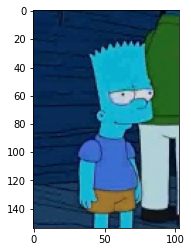

In [21]:
test_path =r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/bart_simpson_15.jpg'

img = cv.imread(test_path)
plt.imshow(img,cmap='gray')
plt.show()

# The image to predict should have same parameters of the training images, so it should be 80x80 and gray.

In [22]:
#Prepare the image

def prepare(img):
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img = cv.resize(img,IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE,1)
    return img

# Make the prediction

In [23]:
predictions = model.predict(prepare(img))


In [24]:
predictions


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# search for the name of the charater with the maximum value in the prediction matrix

In [25]:
print(characters[np.argmax(predictions[0])])

lisa_simpson
